In [1]:
from hashlib import md5
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
def file_hash(x, note=""):
    h = md5()
    h.update(Path(x).read_bytes())
    print(x, h.hexdigest()[:6], note, sep="\t")

## Data dependencies
```
./data/aligned_ac_data.pkl	3324ae	
```

In [3]:
# all_data.csv might be different
file_hash("./data/aligned_ac_data.pkl")

./data/aligned_ac_data.pkl	3324ae	


In [4]:
aligned_ac_data = pd.read_pickle('./data/aligned_ac_data.pkl')

In [5]:
aligned_ac_data.columns

Index(['ac_id', 'has_match', 'time_start', 'time_end', 'time_midpoint',
       'speaker_gender', 'context_raw', 'position', 'syllable_structure',
       'nasalized_perceived', 'function_1', 'function_2', 'nasality',
       'freq_f1', 'freq_f2', 'freq_f3', 'offset_id', 'offset_s', 'bilstm',
       'phone', 'filename', 'comp-1', 'comp-2', 'next_offset_s', 'emit_id',
       'has_midpoint', 'collapse_func'],
      dtype='object')

In [6]:
selected_phones = "[aeioənŋ]"

In [7]:
aligned_ac_data.phone.str.contains(selected_phones).sum()

334

In [8]:
aligned_ac_data.phone.value_counts()

a      133
n       49
x       48
i       48
o       45
ŋ       35
t       18
ɕ       17
ʂ       16
k       13
ə       12
e       12
m       11
j       10
t̪       8
tʰ       8
y        6
u        6
l        6
s        5
t̪ʰ      5
l̪       4
p        3
kʰ       3
s̪       3
ɤ        3
w        3
f        2
Name: phone, dtype: int64

## Visualization

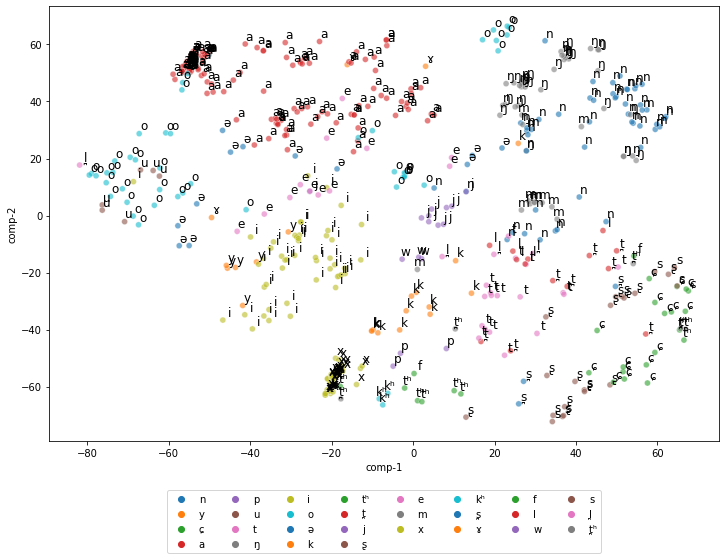

In [9]:

select_phone = False
if select_phone:
    plot_data = aligned_ac_data.loc[aligned_ac_data.phone.str.contains(selected_phones), :]
else:
    plot_data = aligned_ac_data
    
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x="comp-1", y="comp-2", 
                hue="phone",
                palette="tab10",
                alpha=0.6,
                data=plot_data)

for i,row in plot_data.iterrows():
    ax.annotate(row['phone'], 
                (row['comp-1'],row['comp-2']),
                textcoords='offset points',
                xytext=(8,4),
                ha='right',
                fontsize=12)
    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=8)

### Position

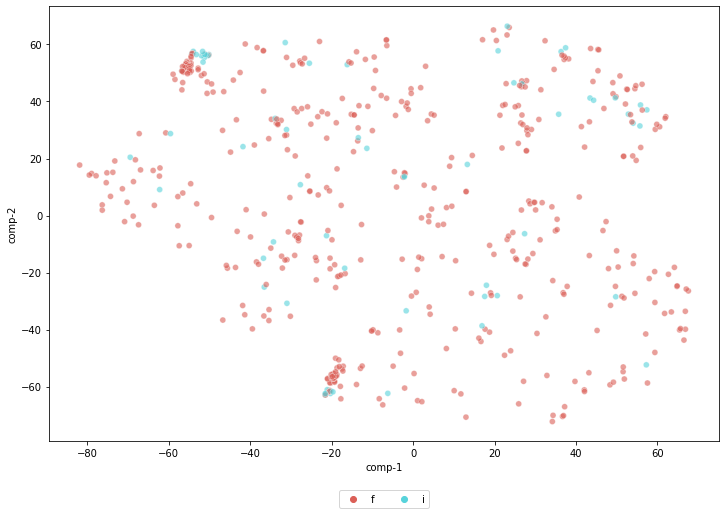

In [10]:
select_phone = False
if select_phone:
    plot_data = aligned_ac_data.loc[aligned_ac_data.phone.str.contains(selected_phones), :]
else:
    plot_data = aligned_ac_data
    
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x="comp-1", y="comp-2", 
                hue="position",
                palette="hls",
                alpha=0.6,
                data=plot_data)

for i,row in plot_data.iterrows():
    ax.annotate(row['phone'], 
                (row['comp-1'],row['comp-2']),
                textcoords='offset points',
                xytext=(8,4),
                ha='right', color='none',
                fontsize=12)
    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=8)

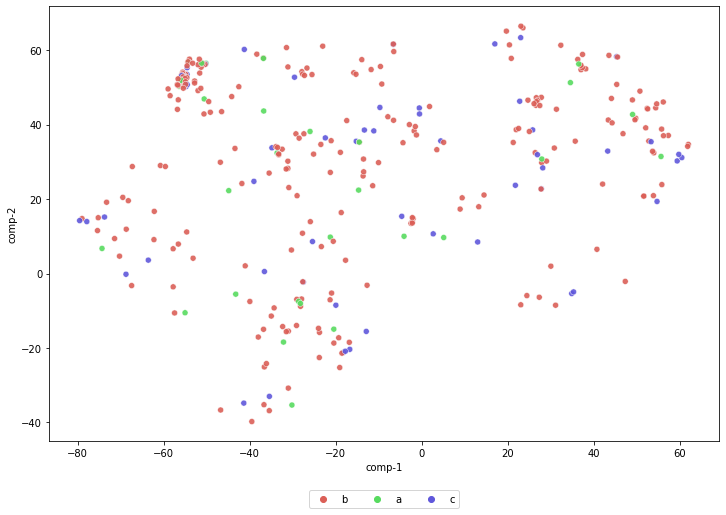

In [11]:

select_phone = True
if select_phone:
    plot_data = aligned_ac_data.loc[aligned_ac_data.phone.str.contains(selected_phones), :]
else:
    plot_data = aligned_ac_data
    
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x="comp-1", y="comp-2", 
                hue="function_1",
                palette="hls",
                alpha=0.9,
                data=plot_data)

for i,row in plot_data.iterrows():
    ax.annotate(row['phone'], 
                (row['comp-1'],row['comp-2']),
                textcoords='offset points',
                xytext=(8,4),
                ha='right', color='none',
                fontsize=12)
    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=8)

## Classifier

In [12]:
def run_linear_svm(labelvar, only_midpoint=False, 
                   select_phone=False, use_acoustic=False, random_state=1234):
    # build embedding matrix 
    
    clf_data = aligned_ac_data
    if only_midpoint:
        clf_data = clf_data.query("has_midpoint")
    if select_phone:
        clf_data = clf_data.loc[clf_data.phone.str.contains(selected_phones)]
    
    if use_acoustic:
        features = clf_data[["freq_f1", "freq_f2", "freq_f3", "nasality"]].to_numpy()
        features = minmax_scale(features)        
    else:
        features = clf_data.bilstm.values.tolist()
    vec_matrix = pd.DataFrame(features, index=clf_data.phone)
    x = vec_matrix
    y = clf_data[labelvar].to_numpy()

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=random_state)

    clf = SVC(kernel='linear')
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    
    dummy = DummyClassifier(strategy='most_frequent')
    dummy.fit(x_train, y_train)
    dummy_pred = dummy.predict(x_test)
    
    print('Total {} phones matching ho'.format(clf_data.shape[0]))
    if only_midpoint:
        print("Only emit frames containing midpoint")
    print('x: bilstm 640, y:', labelvar)
    print('x_train:{}, x_test:{}'.format(x_train.shape, x_test.shape),'\n')

    print('Accuracy: {:.4f} / Dummy: {:.4f}'.format(
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, dummy_pred)))
    print('')
    print(classification_report(y_test, y_pred))

### Position

In [13]:
run_linear_svm("position")

Total 532 phones matching ho
x: bilstm 640, y: position
x_train:(372, 640), x_test:(160, 640) 

Accuracy: 0.8938 / Dummy: 0.8562

              precision    recall  f1-score   support

           f       0.90      0.99      0.94       137
           i       0.80      0.35      0.48        23

    accuracy                           0.89       160
   macro avg       0.85      0.67      0.71       160
weighted avg       0.89      0.89      0.88       160



<div style="border-left: 5px solid navy; font-family: monospace; padding-left: 2%">
    Position (midpoint only) <br>
    Accuracy: 0.7458 / Dummy: 0.7288
</div>

In [14]:
run_linear_svm("position", only_midpoint=True)

Total 194 phones matching ho
Only emit frames containing midpoint
x: bilstm 640, y: position
x_train:(135, 640), x_test:(59, 640) 

Accuracy: 0.7458 / Dummy: 0.7288

              precision    recall  f1-score   support

           f       0.77      0.93      0.84        43
           i       0.57      0.25      0.35        16

    accuracy                           0.75        59
   macro avg       0.67      0.59      0.59        59
weighted avg       0.72      0.75      0.71        59



In [15]:
run_linear_svm("position", select_phone=True)

Total 334 phones matching ho
x: bilstm 640, y: position
x_train:(233, 640), x_test:(101, 640) 

Accuracy: 0.8614 / Dummy: 0.8119

              precision    recall  f1-score   support

           f       0.90      0.93      0.92        82
           i       0.65      0.58      0.61        19

    accuracy                           0.86       101
   macro avg       0.78      0.75      0.76       101
weighted avg       0.86      0.86      0.86       101



In [16]:
run_linear_svm("position", only_midpoint=True, use_acoustic=True)

Total 194 phones matching ho
Only emit frames containing midpoint
x: bilstm 640, y: position
x_train:(135, 4), x_test:(59, 4) 

Accuracy: 0.7288 / Dummy: 0.7288

              precision    recall  f1-score   support

           f       0.73      1.00      0.84        43
           i       0.00      0.00      0.00        16

    accuracy                           0.73        59
   macro avg       0.36      0.50      0.42        59
weighted avg       0.53      0.73      0.61        59



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Discourse Function

In [17]:
run_linear_svm("function_1")

Total 532 phones matching ho
x: bilstm 640, y: function_1
x_train:(372, 640), x_test:(160, 640) 

Accuracy: 0.6937 / Dummy: 0.7688

              precision    recall  f1-score   support

           a       0.07      0.08      0.07        13
           b       0.82      0.86      0.84       123
           c       0.25      0.17      0.20        24

    accuracy                           0.69       160
   macro avg       0.38      0.37      0.37       160
weighted avg       0.67      0.69      0.68       160



<div style="border-left: 5px solid gray; font-family: monospace; padding-left: 2%">
    Function (midpoint only) <br>
    Accuracy: 0.6441 / Dummy: 0.6949
</div>

In [18]:
run_linear_svm("function_1", only_midpoint=True)

Total 194 phones matching ho
Only emit frames containing midpoint
x: bilstm 640, y: function_1
x_train:(135, 640), x_test:(59, 640) 

Accuracy: 0.6441 / Dummy: 0.6949

              precision    recall  f1-score   support

           a       0.14      0.17      0.15         6
           b       0.73      0.85      0.79        41
           c       0.50      0.17      0.25        12

    accuracy                           0.64        59
   macro avg       0.46      0.40      0.40        59
weighted avg       0.62      0.64      0.61        59



In [19]:
run_linear_svm("function_1", only_midpoint=True, use_acoustic=True)

Total 194 phones matching ho
Only emit frames containing midpoint
x: bilstm 640, y: function_1
x_train:(135, 4), x_test:(59, 4) 

Accuracy: 0.6949 / Dummy: 0.6949

              precision    recall  f1-score   support

           a       0.00      0.00      0.00         6
           b       0.69      1.00      0.82        41
           c       0.00      0.00      0.00        12

    accuracy                           0.69        59
   macro avg       0.23      0.33      0.27        59
weighted avg       0.48      0.69      0.57        59



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
run_linear_svm("function_1", select_phone=True)

Total 334 phones matching ho
x: bilstm 640, y: function_1
x_train:(233, 640), x_test:(101, 640) 

Accuracy: 0.6733 / Dummy: 0.7129

              precision    recall  f1-score   support

           a       0.11      0.14      0.12         7
           b       0.78      0.83      0.81        72
           c       0.47      0.32      0.38        22

    accuracy                           0.67       101
   macro avg       0.45      0.43      0.44       101
weighted avg       0.66      0.67      0.67       101



## Collapse function

In [21]:
run_linear_svm("collapse_func")

Total 532 phones matching ho
x: bilstm 640, y: collapse_func
x_train:(372, 640), x_test:(160, 640) 

Accuracy: 0.6687 / Dummy: 0.7688

              precision    recall  f1-score   support

           b       0.80      0.76      0.78       123
           o       0.31      0.35      0.33        37

    accuracy                           0.67       160
   macro avg       0.55      0.56      0.55       160
weighted avg       0.68      0.67      0.68       160



<div style="border-left: 5px solid navy; font-family: monospace; padding-left: 2%">
    Function (midpoint only) <br>
    Accuracy: 0.7458 / Dummy: 0.6949
</div>

In [22]:
run_linear_svm("collapse_func", only_midpoint=True)

Total 194 phones matching ho
Only emit frames containing midpoint
x: bilstm 640, y: collapse_func
x_train:(135, 640), x_test:(59, 640) 

Accuracy: 0.7458 / Dummy: 0.6949

              precision    recall  f1-score   support

           b       0.78      0.88      0.83        41
           o       0.62      0.44      0.52        18

    accuracy                           0.75        59
   macro avg       0.70      0.66      0.67        59
weighted avg       0.73      0.75      0.73        59



In [23]:
run_linear_svm("collapse_func", only_midpoint=True, use_acoustic=True)

Total 194 phones matching ho
Only emit frames containing midpoint
x: bilstm 640, y: collapse_func
x_train:(135, 4), x_test:(59, 4) 

Accuracy: 0.6949 / Dummy: 0.6949

              precision    recall  f1-score   support

           b       0.69      1.00      0.82        41
           o       0.00      0.00      0.00        18

    accuracy                           0.69        59
   macro avg       0.35      0.50      0.41        59
weighted avg       0.48      0.69      0.57        59



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
run_linear_svm("collapse_func", select_phone=True)

Total 334 phones matching ho
x: bilstm 640, y: collapse_func
x_train:(233, 640), x_test:(101, 640) 

Accuracy: 0.6832 / Dummy: 0.7129

              precision    recall  f1-score   support

           b       0.78      0.78      0.78        72
           o       0.45      0.45      0.45        29

    accuracy                           0.68       101
   macro avg       0.61      0.61      0.61       101
weighted avg       0.68      0.68      0.68       101

